<center> 
<h2><b> Adnan Rashid </b></h2>
    <nav>
        <h3>
    | <a href="00-Contents-Setup.ipynb"> Home Page </a> | 
        <a href="http://bit.ly/cka_notes_original"> Kubernetes Notes </a> |
        <a href="https://adnan.study"> Website </a> |
        <a href="https://www.instagram.com/adnans_techie_studies/"> Instagram </a> |
        <a href="https://www.linkedin.com/in/adnanrashid1/"> LinkedIn </a> |
        </h3>
    </nav>
</center>

<h1 style="background:black"><code style="background:black;color:white"><center>Deploying Microservices to EKS Fargate</center></code></h1>

<div class="alert alert-block alert-warning">
<font style="color:black">
<center>In this section we will deploy the 2048 game on EKS Fargate and expose it to the internet using an ALB. 
</center>
</font>
</div>

<center><img src="https://adnanstudyimages.s3-eu-west-1.amazonaws.com/26.jpg" width="50%" height="50%" border=5/></center>

<blockquote>Fargate is a technology that provides on-demand, right-sized compute capacity for containers. <br><Br>

With AWS Fargate, you no longer have to provision, configure, or scale groups of virtual machines to run containers. 

This removes the need to choose server types, decide when to scale your node groups, or optimise cluster packing. 

You can control which pods start on Fargate and how they run with Fargate profiles, which are defined as part of the EKS cluster 


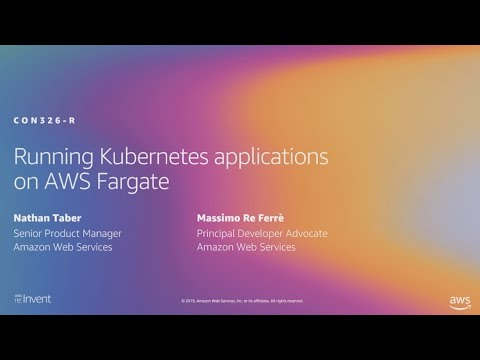

In [42]:
from IPython.display import YouTubeVideo
YouTubeVideo('m-3tMXmWWQw')

## Pre-requisite

* Check your variables are loaded

In [ ]:
%store

* Load in variable store

In [ ]:
%store -r 

* Load variables into notebook

In [ ]:
%env AWS_PROFILE=$AWS_PROFILE
%env AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION
%env ACCOUNT_ID=$ACCOUNT_ID

* Check identity 

In [ ]:
!aws sts get-caller-identity

<br>

---
---

<br>

AWS Fargate with Amazon EKS is currently only avaiable in specific regions 

* We can run the following to verify if AWS Fargate with EKS is available in the Region you choose to deploy your EKS cluster 

In [ ]:
%%bash

if [[ $AWS_DEFAULT_REGION =~ ^(us-east-1|us-east-2|us-west-2|eu-west-1|eu-central-1|ap-southeast-1|ap-southeast-2|ap-northeast-1)$ ]]
then
  echo -e "\033[0;32mAWS Fargate with Amazon EKS is available in your Region."
  echo "You can continue this lab."
else
  echo -e "\033[0;31mAWS Fargate with Amazon EKS is not yet available in your Region ($AWS_REGION)."
  echo "Deploy your cluster in one of the Regions mentioned above."
fi

## <br><br> Creating a Fargate Profile

<blockquote> The fargate profile allows an administrator to declare which pods run on Fargate. 
Each profile can have upto 5 selectors that contain a <b>namespace</b> and optional <b>labels</b><br><br>

You must define a namespace for every selector. <br>
The label field consists of multiple optional key-value pairs. <br>
Pods that match a selector (by matching a namespace for the selector and all of the labels specified in the selector) are scheduled on Fargate. 

It is generally a good practice to deploy user application workloads into namespaces other than <b>kube-system</b> or <b>default</b> so that you have more fine-grained capabilities to manage the interaction between your pods deployed on EKS. <br><br>

You will now create a new Fargate profile named <b> applications</b> that targets all pods destined for the <b>fargate</b> namespace. 

#### <br><br>Create a Fargate profile

In [ ]:
%%bash

eksctl create fargateprofile \
  --cluster eksworkshop-eksctl \
  --name 2048-game \
  --namespace 2048-game

Fargate profiles are immutable. However, you can create a new updated profile to replace an existing profile and then delete the original after the updated profile has finished creating 

When your EKS cluster schedules pods on Fargate, the pods will need to make calls to AWS APIs on your behalf to do things like pull container images from Amazon ECR. 

The Fargate <b>Pod Execution Role</b> provides the IAM permissions to do this. This IAM role is automatically created for you by the above command. 

Creation of a Fargate profile can take up to several minutes. 

* Execute the following command after the profile creation is completed 

In [ ]:
!eksctl get fargateprofile --cluster eksworkshop-eksctl -o yaml 

<br><br>

Notice that the profile includes the private subnets in your EKS cluster. 
Pods running on Fargate are not assigned public IP addresses, so only private subnets (with no direct route to an Internet Gateway) are supported when you create a Fargate profile. <br><br>
Hence, while provisioning an EKS cluster, you must make sure that the VPC that you create contains one or more private subnets. 
When you create an EKS cluster with eksctl utility, under the hoods it creates a VPC that meets these requirements. 

## <br><br> Deploying Pods to Fargate 

* Deploy the game 2048 as a sample application to verify that the ALB Ingress Controller creates an ALB as a result of the Ingress object. 

In [ ]:
!kubectl apply -f alb/2048/namespace.yaml
!kubectl apply -f alb/2048/deployment.yaml
!kubectl apply -f alb/2048/service.yaml

* You can check if a Deployment has completed 

In [ ]:
!kubectl -n 2048-game rollout status deployment 2048-deployment 

* Run the following to list all the nodes in the EKS cluster

In [ ]:
!kubectl get nodes

<blockquote>If you cluster has any worker nodes, they will be listed with a name starting with <b>ip- </b> prefix. <br><Br>

In addition to the worker nodes, if any, there will now be two additional 'fargate' nodes listed. 

These are merely kubelets from the microVMs in which your sample app pods are running under Fargate, posing as nodes to the EKS Control Plane. 

This is how the EKS Control Plane stays aware of the Fargate infrastructure under which the pods it orchestrates are running. 

There will be a 'fargate' node added to the cluster for each pod deployed on Fargate. 

<center><img src="https://www.percona.com/community-blog/wp-content/uploads/2018/10/kubernetes-mysql-operator.png" width="60%" height="60%"/

## Setup Pre-Requitesites for ALB  

#### <br><br>Create an OIDC Provider 

First we will have to setup an OIDC provider with the cluster and create the IAM policy to be used by the ALB Ingress Controller. 

This step requires to give IAM permissions to a Fargate pod running in the cluster using the 'IAM for Service Accounts' feature. 

In [ ]:
%%bash 

eksctl utils associate-iam-oidc-provider \
  --cluster eksworkshop-eksctl \
  --region=$AWS_REGION \
  --approve

#### <br><br> Create an IAM Policy for ALB Ingress 

The next step is to create the IAM poicy that will be used by the ALB Ingress Controller deployment. 

* This policy will be later associated to the Kubernetes Service Account and will allow the ALB Ingress Controller pods to create and manage the ALB's resources in your AWS account for you

In [ ]:
%%bash 

aws iam create-policy \
  --policy-name ALBIngressControllerIAMPolicy \
  --policy-document file://alb/iam-policy.json


#### <br><br> Creating Service Account

* We need the policy's ARN to create the Service Account with proper permissions 

In [ ]:
!aws iam list-policies --query 'Policies[?PolicyName==`ALBIngressControllerIAMPolicy`].Arn' --output text

In [ ]:
%env FARGATE_POLICY_ARN=arn:aws:iam::$ACCOUNT_ID:policy/ALBIngressControllerIAMPolicy

* Next, create a Kubernetes Service Account by executing the following

In [ ]:
%%bash 

eksctl create iamserviceaccount \
  --name alb-ingress-controller \
  --namespace 2048-game \
  --cluster eksworkshop-eksctl \
  --attach-policy-arn ${FARGATE_POLICY_ARN} \
  --approve \
  --override-existing-serviceaccounts

<br><br>This deployed a CloudFormation template that creates an IAM role and attaches the IAM policy to it. The IAM role gets associated with a Kubernetes Service Account

* You can see details of the service account created

In [ ]:
!kubectl get sa alb-ingress-controller -n 2048-game -o yaml

#### <br><br> Create RBAC Role 

* You will have to create a Cluster Role and Cluster Role Binding that grant requisite permissions to the Service Account you just created. 

In [ ]:
!kubectl apply -f alb/rbac-role.yaml 

## <br><br> Deploying ALB Ingress Controller 

We will use Helm to install the ALB Ingress Controller
* Check if Helm is installed 

In [ ]:
!helm version 

* Add helm incubator repository

In [ ]:
!helm repo add incubator http://storage.googleapis.com/kubernetes-charts-incubator

In [ ]:
%%bash 

# Get the VPC ID
export VPC_ID=$(aws eks describe-cluster --name eksworkshop-eksctl --query "cluster.resourcesVpcConfig.vpcId" --output text)


helm --namespace 2048-game install 2048-game \
  incubator/aws-alb-ingress-controller \
  --set image.tag=v1.1.7 \
  --set awsRegion=${AWS_DEFAULT_REGION} \
  --set awsVpcID=${VPC_ID} \
  --set rbac.create=false \
  --set rbac.serviceAccount.name=alb-ingress-controller \
  --set clusterName=eksworkshop-eksctl


* Verify the ingress controller has started 

In [ ]:
!kubectl --namespace=2048-game get pods -l "app.kubernetes.io/name=aws-alb-ingress-controller,app.kubernetes.io/instance=2048-game"

<br><br>
* Execute the following command to watch the progress by looking at the deployment status 

In [ ]:
!kubectl -n 2048-game rollout status deployment 2048-game-aws-alb-ingress-controller

* Get the pods 

In [ ]:
!kubectl get pods -n 2048-game

* Patch the service to be of type 'Load Balancer'

In [ ]:
!kubectl -n 2048-game patch svc service-2048 -p '{"spec": {"type": "LoadBalancer"}}'

In [ ]:
!kubectl get service -n 2048-game

## <br><br> Ingress 

The final step in exposing the 2048-game service through an ingress object. 

* As we target Fargate pod IPs and not EC2 instances, we add an annotation to the ingress to specify the target-type. 

In [ ]:
%env ALB_INGRESS_VERSION=1.1.7

In [ ]:
!kubectl apply -f alb/2048/ingress-fargate.yaml

<blockquote>

This will provision an instance of Internet-facing Application Load Balancer. 

From your AWS Management Console, if you navigate to the EC2 dashboard and then select 'Load Balancers' from the menu on the left, you should see the details of the ALB

Also if you select <b> Target Groups </b> and look at the registered targets under the <b> Targets </b> tab, you will see the IP addresses and ports of the sample app pods listed. 

Notice that the pods have been directly reigstered with the load balancer whereas when we worked with worker nodes in the earlier lab, the IP address of the worker nodes and the NodePort were registered as targets. 

The latter case is the <b> Instance Mode </b> where Ingress traffic starts at the ALB and reaches the Kubernetes worker nodes through each service's NodePort and subsequently reaches the pods through the service's ClusterIP. 

While running under Fargate, ALB operates in <b> IP Mode </b>, where Ingress traffic starts at the ALB and reaches the Kubernetes pod directly. 

Illustration of request routing from an AWS Application Load Balancer to Pods on worker nodes in Instance mode:

<center><img src="https://www.eksworkshop.com/images/fargate/InstanceMode.png" width="20%" height="20%"/><br><br>
    
Illustration of request routing from an AWS Application Load Balancer to Fargate Pods in IP mode:
    
<center><img src="https://www.eksworkshop.com/images/fargate/IPMode.png" width="20%" height="20%"/>
    
At this point, your deployment is complete and you should be able to reach 2048-game service from a browser using the DNS name of the ALB. 
    
    

In [ ]:
!kubectl get service -n 2048-game

<br><br><center><img src="https://www.eksworkshop.com/images/fargate/Browser.png" width="20%" height="20%"/>

## <br><br> Clean Up



In [ ]:
!kubectl delete -f alb/2048/namespace.yaml
!kubectl delete -f alb/2048/deployment.yaml
!kubectl delete -f alb/2048/service.yaml

In [ ]:
!kubectl delete -f alb/2048/ingress.yaml
!helm -n 2048-game delete 2048-game 

In [ ]:
%%bash

eksctl delete iamserviceaccount \
  --name alb-ingress-controller \
  --namespace 2048-game \
  --cluster eksworkshop-eksctl \
  --wait

In [ ]:
!kubectl delete -f alb/rbac-role.yaml 

In [ ]:
!eksctl delete fargateprofile --name 2048-game --cluster eksworkshop-eksctl

In [ ]:
!aws iam delete-policy --policy-arn $FARGATE_POLICY_ARN